In [1]:
import sys
import platform
from os.path import join, exists, abspath, dirname
from os import getcwd, makedirs
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm, colors
import scipy
from scipy.stats import ttest_1samp, pearsonr
from scipy.io import loadmat
from sklearn.metrics import r2_score
import seaborn as sns
import h5py

from tqdm import tqdm

In [2]:
import nibabel as nb
from nilearn import plotting, image
from nipype.interfaces import fsl

In [3]:
dir_current = getcwd().replace('\\','/')

tmp = dir_current.split('/')
idx = [ii for ii, s in enumerate(tmp) if s=='github'][0]

dir_git = '/'.join(tmp[:idx+1])
dir_git

'/home/sungbeenpark/github'

In [4]:
dname = join(dir_git,'nitools')
sys.path.append(dname)
import nitools as nt

In [5]:
dname = join(dir_git,'SUITPy')
sys.path.append(dname)
import SUITPy as suit

In [6]:
dname = join(dir_git)
sys.path.append(dname)
import surfAnalysisPy as surf

In [7]:
dname = join(dir_git,'Functional_Fusion')
sys.path.append(dname)
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel

In [8]:
dname = join(dir_git,'fracridge')
sys.path.append(dname)
from fracridge import fracridge

In [9]:
dname = join(dir_git,'GLMsingle')
sys.path.append(dname)
import glmsingle
from glmsingle.glmsingle import getcanonicalhrflibrary
from glmsingle.utils.squish import squish

In [10]:
dname = join(dir_git,'SeqSpatialSupp_fMRI')
sys.path.append(dname)
from SSS import deal_spm
from SSS import util as su
from SSS import plot as splt
from SSS import image as simage
from SSS import glmsingle as ssingle

---

In [11]:
list_run = su.get_list_run()
list_run

['r01', 'r02', 'r03', 'r04', 'r05', 'r06', 'r07', 'r08']

---

In [12]:
glm = 1
dir_glm = ssingle.get_dir_glmsingle(glm)
dir_glm

'/mnt/f/SeqSpatialSupp_fMRI/GLMsingle/glm_1'

---

## Load the model

In [13]:
subj = 'S01'

In [14]:
model = ssingle.load_model(subj, glm, type='D')
model.keys()

<KeysViewHDF5 ['#refs#', 'FRACvalue', 'HRFindex', 'HRFindexrun', 'R2', 'R2run', 'glmbadness', 'meanvol', 'modelmd', 'noisepool', 'pcnum', 'pcregressors', 'pcvoxels', 'rrbadness', 'scaleoffset', 'xvaltrend']>

### R2 Map

(116, 116, 57)


/tmp/ipykernel_298542/1075691544.py:3: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  plotting.plot_glass_brain(r2nii, cmap=cm.Reds, colorbar=True)


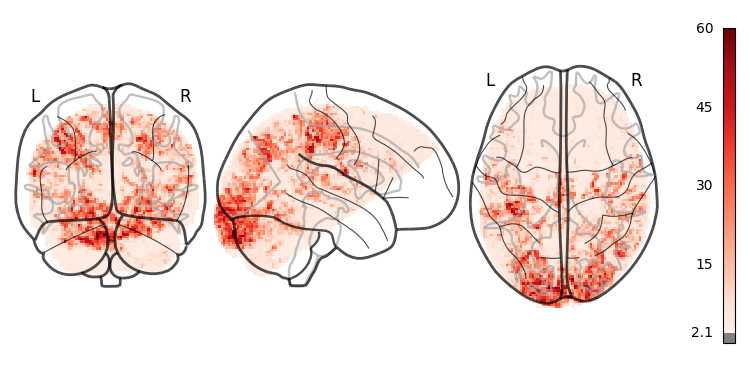

In [15]:
r2nii = ssingle.get_R2_map(subj, glm, type='D')
print(r2nii.shape)
plotting.plot_glass_brain(r2nii, cmap=cm.Reds, colorbar=True)
# plotting.view_img(stat_map_img=r2nii, cmap=cm.Reds, vmin=0, vmax=20, colorbar=True, symmetric_cmap=False)

In [16]:
# #Find a voxel with highest variance explained of the ON-OFF model
# R2flatten = r2nii.get_fdata().flatten()
# print(R2flatten.shape)

# idx = np.unravel_index(np.nanargmax(R2flatten), np.shape(r2nii))
# print(idx, r2nii.get_fdata()[idx])

# del R2flatten

$$
\begin{aligned}
-94 &\leq x \leq 98 \\
-132 &\leq y \leq 98 \\
-70 &\leq z \leq 118
\end{aligned}
$$

Affine Transformation Matrix:

voxel(index) coordinate $(i,j,k)$ $\rightarrow$ world coordinate $(x,y,z)$
$$
\begin{bmatrix}
x \\
y \\
z \\
1
\end{bmatrix}
=
\begin{bmatrix}
a_{11} & a_{12} & a_{13} & a_{14} \\
a_{21} & a_{22} & a_{23} & a_{24} \\
a_{31} & a_{32} & a_{33} & a_{34} \\
a_{41} & a_{42} & a_{43} & a_{44}
\end{bmatrix}
\begin{bmatrix}
i \\
j \\
k \\
1
\end{bmatrix}
$$

In [17]:
# coord = [-32, -18, 36, 1]
# idx = (np.linalg.inv(mask.affine)@coord)[:3].astype(int)
# idx = tuple(idx)
# print(idx, r2nii.get_fdata()[idx])

### $\beta$ Map

In [18]:
betanii = ssingle.get_beta_map(subj=subj, glm=glm, type='D')
print(betanii.shape)
# plotting.plot_glass_brain(image.index_img(betanii, index=10))

(116, 116, 57, 544)


In [19]:
reginfo = deal_spm.load_reginfo(subj=subj,dir_glm=dir_glm)
reginfo

,sn,run,name,ons
0,1,1,"(2,S)",6.03
1,1,1,"(4,S)",11.03
2,1,1,"(4,L)",16.03
3,1,1,"(2,L)",21.03
4,1,1,"(1,S)",26.03
...,...,...,...,...
539,1,8,"(3,S)",3215.03
540,1,8,"(3,L)",3220.03
541,1,8,"(2,S)",3225.03
542,1,8,"(2,L)",3230.03


In [20]:
idx_letter = np.array([True if 'L' in name else False for name in reginfo.name])
idx_spatial = np.array([True if 'S' in name else False for name in reginfo.name])

### Find HRF estimated by GLMsingle

In [21]:
tr, stimdur, _ = ssingle.get_TR_stimdur_stimorder(subj=subj, glm=glm)
print(tr, stimdur)

1.0 2.0


### HRF index Map

(116, 116, 57)


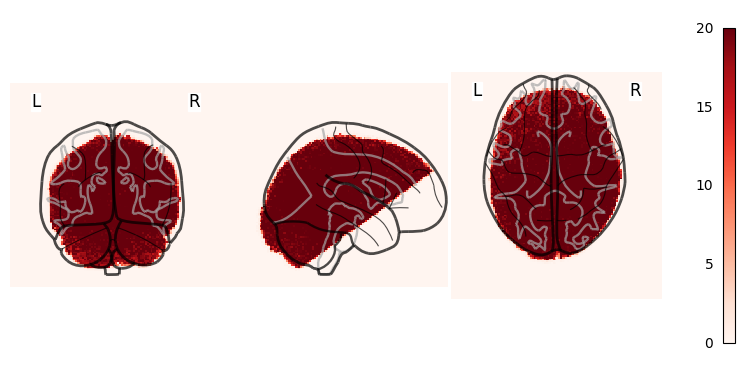

In [22]:
hrfnii = ssingle.get_index_map(subj, glm, type='D')
print(hrfnii.shape)
# plotting.view_img(hrfnii, vmin=0, vmax=20, symmetric_cmap=False, cmap=cm.Reds)
plotting.plot_glass_brain(hrfnii, cmap=cm.Reds, colorbar=True, threshold=None)

(52, 20)


<Axes: >

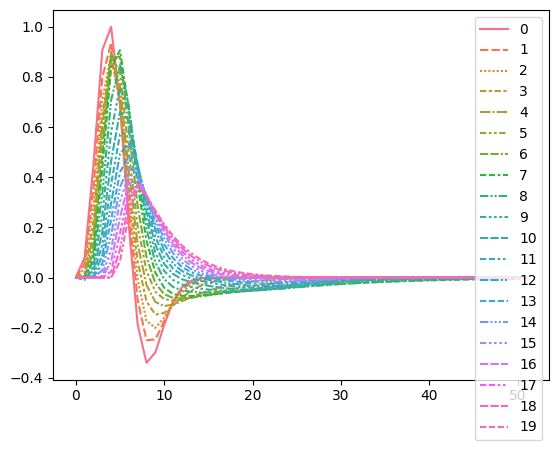

In [23]:
hrflib = getcanonicalhrflibrary(stimdur,tr).T
print(hrflib.shape)
sns.lineplot(hrflib)

Text(0.5, 1.0, 'The number of indecies')

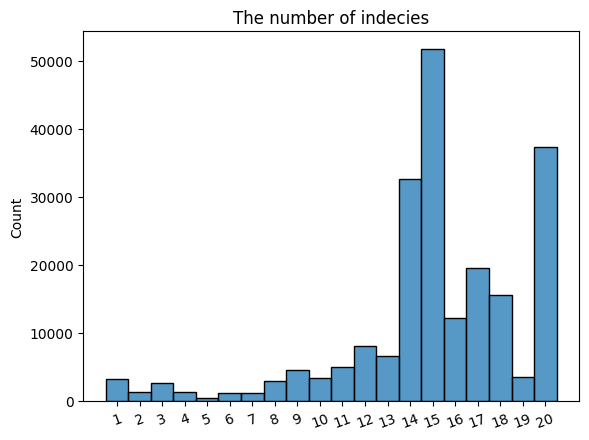

In [24]:
tmp = hrfnii.get_fdata().astype(int).reshape(-1)
g = sns.histplot(tmp[tmp>0], discrete=True)
xticks = np.arange(20)+1
g.set_xticks(xticks)
g.set_xticklabels(xticks, rotation=20)
g.set_title('The number of indecies')

### Mean Volume

(116, 116, 57)


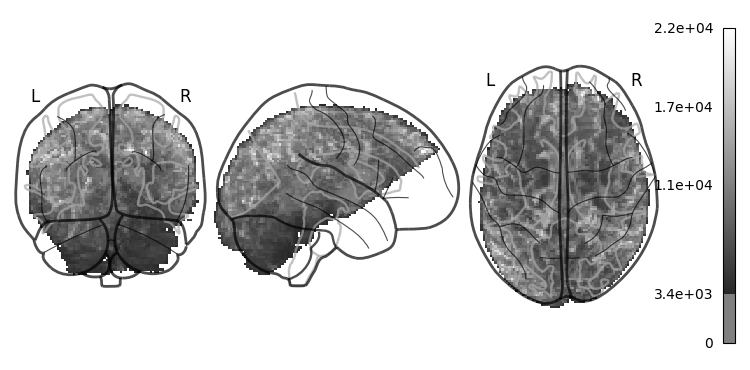

In [25]:
meanvolnii = ssingle.get_meanvol(subj=subj, glm=glm, type='D')
print(meanvolnii.shape)
plotting.plot_glass_brain(meanvolnii, cmap=cm.gray, colorbar=True, threshold='auto')

---
---

In [26]:
run = 1
rr = 0

In [27]:
subj = 'S01'

### Load Y_raw

In [28]:
y_raw = simage.load_yraw(subj=subj, run=run)
y_raw.shape

(116, 116, 57, 410)

$$
Y_{raw} = X_{conv}\beta+\epsilon
$$

---

### Design Matrix of Noise

In [29]:
model['pcvoxels'][:] # mask

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [30]:
## The number of PCs used in the final model is stored in 'pcnum'
pcnum = int(model['pcnum'][:].reshape(-1)[0])

In [31]:
## Get the GLMdenoise Principal Components for Run
rr = 2
tmp = model['pcregressors'][:]
ref = tmp[rr,0]
pcregressor = model[ref][:].T
print(pcregressor.shape)
pcregressor = pcregressor[:,:pcnum]

(407, 10)


In [32]:
designinfo = ssingle.load_designinfo(subj=subj, glm=glm)
designinfo.keys()

<KeysViewHDF5 ['#refs#', 'condcounts', 'condinruns', 'design', 'designSINGLE', 'endbuffers', 'numtrialrun', 'opt', 'stimdur', 'stimorder', 'tr']>

In [33]:
ref = designinfo['designSINGLE'][:][rr,0]
design = designinfo[ref][:].T
design.shape

(407, 544)

In [34]:
## Generate the Polynomial Regressors
nTR = len(design)
run_duration_min = (nTR * tr) / 60;
poly_degree = round(run_duration_min * 0.5);
print(poly_degree)

3


In [35]:
## Create the polynomial regressors (including the constant term)
polynomial_regressors = np.zeros((nTR, poly_degree+1));
polynomial_regressors.shape

(407, 4)

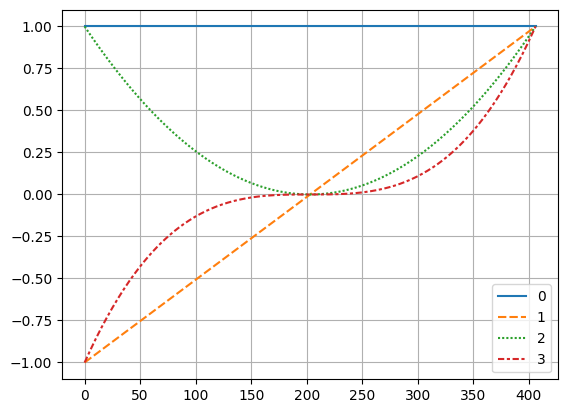

In [36]:
polynomial_regressors[:,0] = 1.
for p in np.arange(poly_degree):
    polynomial_regressors[:,p+1] = np.linspace(-1, 1, nTR) ** (p+1)
g = sns.lineplot(polynomial_regressors)
g.legend()
g.grid()

In [37]:
## Combine into a single nuisance regressor matrix
## Also add any 'extraregressors' you might have used
extra_regs = [] # Populate this if you used opt.extraregressors

<Axes: >

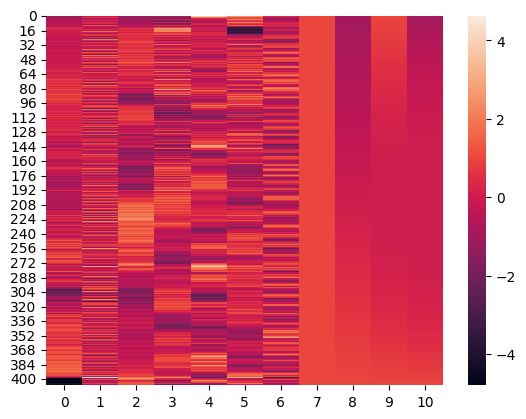

In [38]:
design_noise = np.hstack([pcregressor, polynomial_regressors])
sns.heatmap(design_noise)

<Axes: >

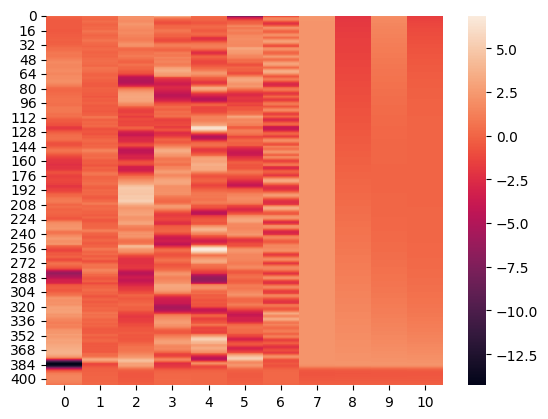

In [39]:
# convolve HRF into design matrix
hrf = hrflib[:,10]
design_noise_conv = scipy.signal.convolve2d(design_noise, hrf[:,np.newaxis], mode='same')
sns.heatmap(design_noise_conv)

---
---